# Generating thousands of images

These landscapes will be used to train generative ML models. Therefore, we need a few thousand images for training and testing. This notebook will have similar commands as the `Example` notebook, but will make many images with the same format and save them all.

I am going to update this to randomize a few things:

1. Randomize where the horizon appears. As it stands, every image had $R(\theta)=[-15,30]$, which means the models can learn the horizon boundary too easily.

2. Randomize the number of trees. Previously all landscapes had 25 trees unless they randomly appeared directly in front of one another. Now I'll draw from a Poisson distribution to figure out how many trees.

3. Randomize the "scene" between a sunset with darkening skies and a bright fall day where the trees are more reddish.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import LandscapeGenerator as LG

In [3]:
np.random.seed(1234)

In [7]:
#Create some objects that will be reused to avoid calling constructors many times
field_of_view = np.zeros((2, 2))
field_of_view[1, 0:2] = 0, 360
M, N = 128, 128*8
dimensions = [M, N]
L = LG.LGenerator(dimensions)

In [8]:
def get_random_FOV():
    dtheta = 0*npr.randn()
    field_of_view[0, 0:2] = -15 + dtheta, 30 + dtheta
    return field_of_view

In [9]:
def make_tree(leaf_rgb_means = [80, 160, 110],
              trunk_rgb_means = [105, 75, 50]):
    return LG.TreeFeature(height = 6 + 2*npr.rand(),
                          branch_radius = 1.5 + npr.rand(),
                          distance = 6 + 40*npr.rand(),
                          phi = 360 * npr.rand(),
                          leaf_rgb_means = leaf_rgb_means + 20*npr.randn(3),
                          trunk_rgb_means = trunk_rgb_means + 5*npr.randn(3))

In [10]:
def make_sunset_landscape():
    L.clear_features()
    L.set_field_of_view(get_random_FOV())
    
    L.add_feature(LG.SkyFeature(rgb_means = [20, 100, 200], rgb_SDs = [5, 5, 5]))
    L.add_feature(LG.SkyFeature(theta_boundary = 10, rgb_means = [20, 80, 160], rgb_SDs = [5, 5, 5]))
    L.add_feature(LG.SkyFeature(theta_boundary = 20, rgb_means = [5, 40, 120], rgb_SDs = [5, 5, 5]))
    L.add_feature(LG.GrassFeature(theta_boundary = 0))
    L.add_feature(LG.GrassFeature(theta_boundary = -5, rgb_means=[50, 200, 70]))
    L.add_feature(LG.SunFeature(theta = 10*npr.rand(), phi = 360 * npr.rand()))
    L.add_feature(LG.SkyGradientFeature(rgb_peaks = [150, 0, 50]))

    Ntrees = npr.poisson(25)
    trees = [make_tree() for _ in range(Ntrees)]
    trees.sort(key = lambda x: x.distance, reverse = True)
    for t in trees:
        L.add_feature(t)
    return L.generate()

In [11]:
def make_fall_landscape():
    L.clear_features()
    L.set_field_of_view(get_random_FOV())
    
    L.add_feature(LG.SkyFeature(rgb_means = [60, 210, 240], rgb_SDs = [5, 5, 5]))
    L.add_feature(LG.GrassFeature(theta_boundary = 0, rgb_means=[50, 230, 70]))
    L.add_feature(LG.GrassFeature(theta_boundary = -5, rgb_means=[50, 230, 120]))
    L.add_feature(LG.SunFeature(theta = L.field_of_view[0, 1] * npr.rand(), phi = 360 * npr.rand()))
    #L.add_feature(LG.SkyGradientFeature(rgb_peaks = [150, 0, 50]))

    Ntrees = npr.poisson(25)
    trees = [make_tree(leaf_rgb_means = [190, 70, 45], trunk_rgb_means = [105, 80, 65]) for _ in range(Ntrees)]
    trees.sort(key = lambda x: x.distance, reverse = True)
    for t in trees:
        L.add_feature(t)
    return L.generate()

In [12]:
N_pics = 10
data = np.zeros((N_pics, M, N, 3))

for i in range(N_pics):
    if npr.randint(2):
        data[i] = make_sunset_landscape()
    else:
        data[i] = make_fall_landscape()
#np.save(f"panoramas_{M}x{N}_Npics{N_pics}_rgb", data)

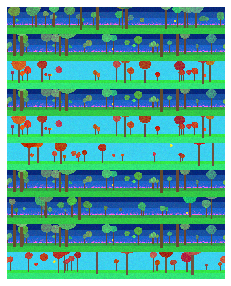

In [13]:
#Visualize
nr = 10
fig, ax = plt.subplots(nr, 1, figsize=(20, 5))
plt.subplots_adjust(hspace=0)
#ax[2].set_xticks([])
#ax[2].set_xticklabels([])
for i in range(nr):
    ax[i].axis("off")
    #ax[i].set_yticks([])
    #ax[i].set_yticklabels([])
    ax[i].imshow(data[np.random.randint(low = 0, high = N_pics)])

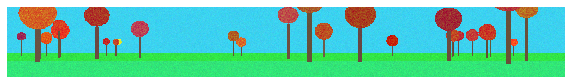

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(data[3])
ax.axis("off")
fig.savefig("example2.png", dpi=400, bbox_inches="tight", transparent=True)